# Download Data

In [ ]:
# File Name

url = "https://www.dropbox.com/scl/fi/wphgza0mjlydbr4zunyhe/padl-concrete-crack-detection.zip?rlkey=myi6h7adrlmu7gncbx1ygizmx&st=fxr3ei1d&dl=1"
filename = 'data/padl-concrete-crack-detection.zip'
data_dir = 'data/padl-concrete-crack-detection'

In [3]:
# Data download

from pathlib import Path
Path("data").mkdir(exist_ok=True)  # create 'data' folder

import os
if not os.path.exists(filename):
    # install and import wget library to download the data file
    !pip install wget
    import wget
    wget.download(url, filename)

import zipfile
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Load Data

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")
print("Device:", device)

c:\Users\acer1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Device: cpu


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

data_dir = 'data/padl-concrete-crack-detection/padl-concrete-crack-detection'

image_width = 64     # TODO: Change the image size to optimize the performance
image_height = 64    # TODO: Change the image size to optimize the performance
batch_size = 32      # TODO: Change the batch size to optimize the performance
transform = transforms.Compose([   # TODO: Explore other image transformations to optimize the performance
    transforms.Grayscale(),
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)  # TODO: We are flattening image to a 1D vector to make it compatible with MLP. For CNN, remove this line.
])
dataset = datasets.ImageFolder(data_dir + '/train', transform=transform)

dataset_size = len(dataset)
train_size = int(0.8*dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

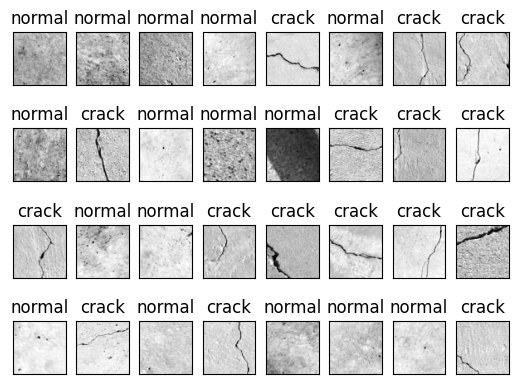

In [4]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.figure()
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,8,i+1)
    plt.imshow(image.reshape(image_height,image_width),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(dataset.classes[label])

# Model Design

In [5]:
import torch.nn as nn

class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # TODO: Try different architecture design (e.g., your own CNN, transfer a pre-trained CNN, etc.)
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # TODO: Try different architecture design
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
    
model = SimpleClassifier(num_inputs=image_height*image_width, num_hidden=4096, num_outputs=1)

# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=4096, out_features=4096, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4096, out_features=1, bias=True)
)


# For Android 

In [8]:
num_inputs = image_height * image_width

checkpoint = torch.load("checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
# Export to TorchScript
example_input = torch.rand(1, num_inputs)  # batch of 1, flattened image
traced_script_module = torch.jit.trace(model, example_input)

# Save model
traced_script_module.save("model.pt")

# Train

In [6]:
# TODO: Try different optimizers and parameter combinations
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)



In [21]:
# Load checkpoint
checkpoint = torch.load('checkpoint21.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
current_loss = checkpoint['loss']

In [23]:
print(last_epoch)

21100


In [ ]:
model.to(device)    # Load the model to the device

loss_module = nn.BCEWithLogitsLoss()

# Training loop
num_epochs =100   # TODO: Increase the number of epochs (e.g., 1000) to see if it converges better
for epoch in range(last_epoch,last_epoch+2000 ):  # Train 10 more epochs
    model.train()       # Set model to train mode
    running_loss = 0
    for i, (data_inputs, data_labels) in enumerate(train_loader):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels.float())

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        ## Step 6: Print the progress before moving to the next iteration
        running_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch} loss: {running_loss/(i+1)}", end='\r')
    avg_train_loss = running_loss / i

    # Repeat the same, but this time on the validation data to evaluate the progress
    model.eval()       # Set model to evaluation mode
    running_val_loss = 0
    for i, (data_inputs, data_labels) in enumerate(val_loader):
        
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        preds = model(data_inputs)
        preds = preds.squeeze(dim=1)

        loss = loss_module(preds, data_labels.float())

        # For validation data, we skip backpropagation (we are not training!)

        running_val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch} - loss: {avg_train_loss}, val: {running_val_loss/(i+1)}", end='\r')
    print('')

 # Save checkpoint again
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
 }, 'checkpoint2.pth')    

Epoch 15100 - loss: 0.26969196771581966, val: 0.47976069152355194
Epoch 15101 - loss: 0.2603156926731269, val: 0.49942898750305176
Epoch 15102 - loss: 0.2640782321492831, val: 0.49898501858115196
Epoch 15103 - loss: 0.2647672922660907, val: 0.4754539877176285
Epoch 15104 - loss: 0.26226530348261196, val: 0.5196013376116753
Epoch 15105 - loss: 0.2575906713803609, val: 0.47551144659519196
Epoch 15106 - loss: 0.26187823091944057, val: 0.4751497954130173
Epoch 15107 - loss: 0.2615710347890854, val: 0.5039938539266586
Epoch 15108 - loss: 0.2725725844502449, val: 0.5478329285979271
Epoch 15109 - loss: 0.26538607602318126, val: 0.48263220489025116
Epoch 15110 - loss: 0.2777628004550934, val: 0.5295712985098362
Epoch 15111 - loss: 0.27553127333521843, val: 0.5708103105425835
Epoch 15112 - loss: 0.26291920617222786, val: 0.4830325245857239
Epoch 15113 - loss: 0.25462407742937404, val: 0.4779392145574093
Epoch 15114 - loss: 0.2567877781887849, val: 0.5004019103944302
Epoch 15115 - loss: 0.257923

In [24]:

# Save checkpoint again
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
 }, 'checkpoint.pth')

NameError: name 'epoch' is not defined

In [25]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [26]:
eval_model(model, train_loader)



Accuracy of the model: 97.20%


In [27]:
eval_model(model, val_loader)


Accuracy of the model: 96.97%



# Submission

Now that we have a model trained, let's evaluate it on the test data. To do so, we create a separate test data loader.

In [28]:
import os
from PIL import Image

# Custom dataset class to keep track of the filename
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

In [29]:
test_transform = transforms.Compose([   # Be careful: No other data augmentation should be included in test transform
    transforms.Grayscale(),
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)  # TODO: We are flattening image to a 1D vector to make it compatible with MLP. For CNN, remove this line.
])
test_dataset = TestDataset(data_dir + '/test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [30]:
model.eval() # Set model to eval mode

predictions = {}
with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, filenames in test_loader:

        # Infer model on a test batch
        data_inputs = data_inputs.to(device)
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1)
        preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1

        print("pridection: ",preds)
        pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

        for filename, pred in zip(filenames, pred_labels):
            predictions[filename] = int(pred.detach().cpu().numpy())

#print(predictions)

pridection:  tensor([0.4948, 0.5868, 0.8469, 0.8735, 0.0955, 0.4713, 0.7797, 0.8933, 0.9674,
        0.5245, 0.6848, 0.9362, 0.3990, 0.9683, 0.9279, 0.1281, 0.9130, 0.4655,
        0.4809, 0.1141, 0.6095, 0.7717, 0.9549, 0.3191, 0.6753, 0.8509, 0.2633,
        0.6755, 0.2179, 0.9017, 0.5318, 0.0127])
pridection:  tensor([7.3319e-01, 6.4271e-01, 5.4105e-01, 8.5421e-01, 8.4833e-01, 2.8913e-03,
        2.3723e-01, 6.5303e-01, 2.3219e-01, 4.0969e-01, 5.6551e-01, 1.8242e-01,
        2.2096e-05, 8.4455e-01, 1.8058e-01, 9.1500e-01, 1.5549e-01, 2.5563e-01,
        9.2070e-01, 9.2501e-01, 9.7062e-01, 4.1946e-02, 6.4910e-02, 9.5165e-01,
        3.2208e-01, 1.1591e-01, 4.7317e-01, 3.4662e-01, 7.8927e-01, 7.6908e-01,
        9.6222e-01, 2.4198e-01])
pridection:  tensor([0.8922, 0.5964, 0.7108, 0.3779, 0.6857, 0.8983, 0.5329, 0.8313, 0.6880,
        0.8432, 0.6861, 0.4308, 0.7773, 0.3563, 0.3004, 0.8144, 0.9026, 0.9960,
        0.8256, 0.2607, 0.8774, 0.9383, 0.4936, 0.6701, 0.6700, 0.9573, 0.8241,

In [31]:
import csv

# Write the result to a CSV file
csv_file = 'submission.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(['FILENAME', 'TARGET'])
    # Write content
    for filename, label in predictions.items():
        writer.writerow([filename, label])

print(f"Prediction results have been successfully written to {csv_file}")

Prediction results have been successfully written to submission.csv
